In [110]:
import torch
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
import random
import os
from glob import glob
from PIL import Image

In [45]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [129]:
classes = ['acne', 'chickenpox', 'cowpox', 'measles', 'melanoma', 'monkeypox', 'normal', 'other', 'smallpox']

In [160]:
def get_precision_recall_f1_accuracy(preds, actual):
    tp = torch.logical_and(preds, actual).sum().item()
    tn = torch.logical_and(torch.logical_not(preds), torch.logical_not(actual)).sum().item()
    fp = torch.logical_and(preds, torch.logical_not(actual)).sum().item()
    fn = torch.logical_and(torch.logical_not(preds), actual).sum().item()
    
    precision = tp / (tp + fp + 0.00001)
    recall = tp / (tp + fn + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    accuracy = (tp + tn)/ (tp + tn + fp + fn + 0.00001)
    
    return precision, recall, f1, accuracy

In [128]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, indices, transform=None):
        self.idx_to_class = classes
        self.class_to_idx = {disease: idx for idx, disease in enumerate(self.idx_to_class)}
        self.image_paths = glob(os.path.join(root_dir, "*", "*"))
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        idx = self.indices[index]
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        disease = os.path.basename(os.path.dirname(image_path))
        
        return self.transform(image), torch.tensor(self.class_to_idx[disease])

In [130]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((224, 224), (0.7, 1)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomRotation(15),
    transforms.RandomPosterize()
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

In [131]:
size = len(glob(os.path.join('data/combined', "*", "*")))
train_size = int(size * 0.8)
indices = list(range(size))
random.shuffle(indices)
train_set = CustomDataset('data/combined', indices[:train_size], train_transform)
val_set = CustomDataset('data/combined', indices[train_size:], val_transform)

In [132]:
train_loader = DataLoader(train_set, 8, shuffle=True)
val_loader = DataLoader(val_set, 8, shuffle=False)

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [156]:
model = resnet50()
model.load_state_dict(torch.load("/home/dilith/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth"))
model.fc = torch.nn.Linear(2048, len(classes))
model = model.to(device)

In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [158]:
mp_idx = train_set.class_to_idx["monkeypox"]
metrics = {phase: {metric: [] for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}

In [166]:
for i in range(40):
    ep_metrics = {phase: {metric: 0 for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        loss = criterion(out, label)
        
        bsz = image.size(0)
        ep_metrics['train']['loss'] += loss.item() * bsz
        prec, rec, f1, acc = get_precision_recall_f1_accuracy(out.argmax(dim=1) == mp_idx, label == mp_idx)
        ep_metrics['train']['prec'] += prec * bsz
        ep_metrics['train']['rec'] += rec * bsz
        ep_metrics['train']['f1'] += f1 * bsz
        ep_metrics['train']['acc'] += acc * bsz
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            
            out = model(image)
            loss = criterion(out, label)
            
            bsz = image.size(0)
            ep_metrics['val']['loss'] += loss.item() * bsz
            prec, rec, f1, acc = get_precision_recall_f1_accuracy(out.argmax(dim=1) == mp_idx, label == mp_idx)
            ep_metrics['val']['prec'] += prec * bsz
            ep_metrics['val']['rec'] += rec * bsz
            ep_metrics['val']['f1'] += f1 * bsz
            ep_metrics['val']['acc'] += acc * bsz
            
    
    for phase in ep_metrics:
        for metric in ep_metrics[phase]:
            ep_metrics[phase][metric] /= len(train_set if phase == 'train' else val_set)
            metrics[phase][metric].append(ep_metrics[phase][metric])
            
    print(ep_metrics)

{'train': {'loss': 0.9651929712321454, 'acc': 0.8445219123028014, 'prec': 0.6535077737256096, 'rec': 0.7322601555955849, 'f1': 0.658597459100164}, 'val': {'loss': 1.2697880659414373, 'acc': 0.8217381032621537, 'prec': 0.5820257958667848, 'rec': 0.5489824880405235, 'f1': 0.5358876283264615}}
{'train': {'loss': 0.940055868910136, 'acc': 0.8407165351137302, 'prec': 0.6602123446557352, 'rec': 0.7406498738315442, 'f1': 0.660432817633325}, 'val': {'loss': 1.2563532458699267, 'acc': 0.7619555692946692, 'prec': 0.5099981291634053, 'rec': 0.7075323192545548, 'f1': 0.5611811048076183}}
{'train': {'loss': 0.9009444069752197, 'acc': 0.8488709147491258, 'prec': 0.6715196720462506, 'rec': 0.7382398533424556, 'f1': 0.6635124552497177}, 'val': {'loss': 1.3061302472715792, 'acc': 0.8184772377730185, 'prec': 0.5899970058883496, 'rec': 0.60666329707688, 'f1': 0.5698348319045801}}
{'train': {'loss': 0.8762569609106996, 'acc': 0.8640924232141827, 'prec': 0.6967256134807497, 'rec': 0.7525916060015547, 'f1':

train loss


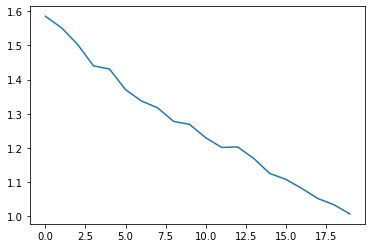

train acc


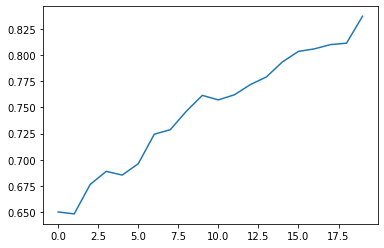

train prec


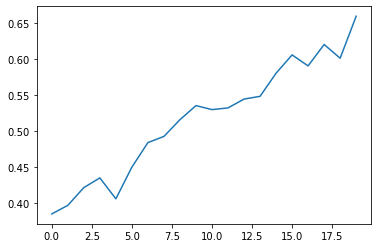

train rec


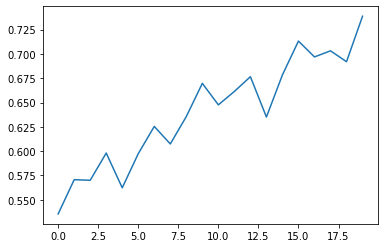

train f1


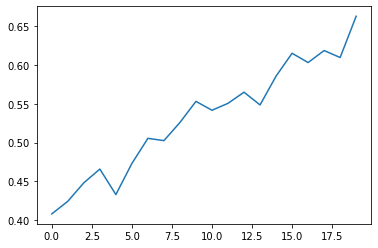

val loss


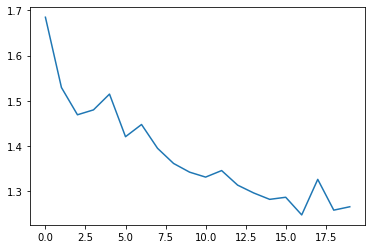

val acc


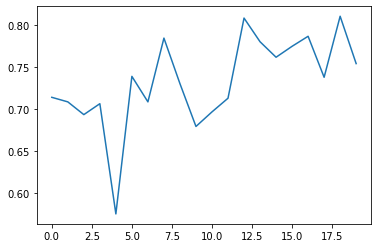

val prec


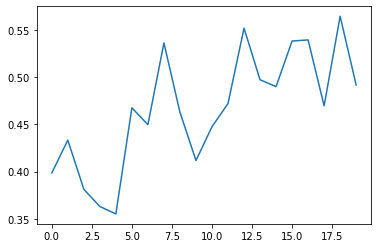

val rec


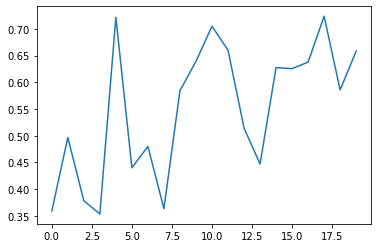

val f1


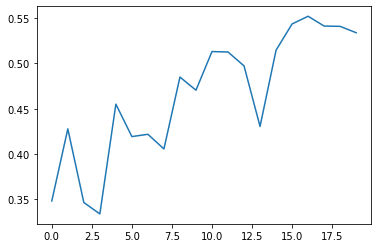

In [165]:
import matplotlib.pyplot as plt

for phase in metrics:
    for metric in metrics[phase]:
        print(phase, metric)
        plt.plot(range(len(metrics[phase][metric])), metrics[phase][metric])
        plt.show()